<a href="https://colab.research.google.com/github/Andrey239/ML_LPI_2021/blob/main/seminar11/MLatFIAN2021_seminar11_AutoencodersAndSemiSupervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoder example

In this example we'll show how an auto-encoder can help when labeled data is limited. Will take the MNIST data keeping only the labels of first 300 examples (out of 60000).

In [1]:
import numpy as np

import tensorflow as tf
tf.__version__

'2.7.0'

Load and preprocess the data (as numpy arrays):

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = (X_train / 255).astype('float32')
X_test  = (X_test  / 255).astype('float32')

11501568/11490434 [==============================] - 0s 0us/step


Basic autoencoder architecture:

In [11]:
ll = tf.keras.layers
activation = tf.nn.relu

encoder = tf.keras.Sequential([
    ll.Reshape((28, 28, 1), input_shape=(28, 28)),

    ll.Conv2D(16, 3, padding='same', activation=activation),
    ll.MaxPool2D(), # 14x14

    ll.Conv2D(32, 3, padding='same', activation=activation),
    ll.MaxPool2D(), # 7x7

    ll.Conv2D(64, 3, padding='valid', activation=activation), # 5x5
    ll.Conv2D(128, 3, padding='valid', activation=activation), # 3x3
    ll.Conv2D(256, 3, padding='valid', activation=activation), # 1x1
    ll.Conv2D(32, 1, padding='same', activation=activation),

    ll.Reshape((32,))
  ],
  name='encoder')

decoder = tf.keras.Sequential([
    ll.Reshape((1, 1, 32), input_shape=(32,)),

    ll.UpSampling2D(), # 2x2
    ll.Conv2D(256, 3, padding='same', activation=activation),

    ll.UpSampling2D(), # 4x4
    ll.Conv2D(128, 3, padding='same', activation=activation),

    ll.UpSampling2D(), # 8x8
    ll.Conv2D(64, 3, padding='same', activation=activation),

    ll.UpSampling2D(), # 16x16
    ll.Conv2D(32, 3, padding='valid', activation=activation), # 14x14

    ll.UpSampling2D(), # 28x28
    ll.Conv2D(16, 3, padding='same', activation=activation),
    ll.Conv2D(1, 1, padding='valid', activation=activation),

    ll.Reshape((28, 28))
  ],
  name='decoder')

autoencoder = tf.keras.Sequential([
  encoder,
  decoder
])

autoencoder.summary()
autoencoder.compile(optimizer=tf.optimizers.Adam(), loss=tf.keras.losses.MSE)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Sequential)        (None, 32)                400544    
                                                                 
 decoder (Sequential)        (None, 28, 28)            465921    
                                                                 
Total params: 866,465
Trainable params: 866,465
Non-trainable params: 0
_________________________________________________________________


Trainign it on the whole train dataset (note that `X_train` is both inputs and targets for the autoencoder, i.e. we are not using the labels `y_train`):

In [12]:
autoencoder.fit(x=X_train, y=X_train, batch_size=256, epochs=16, validation_data=(X_test, X_test));

Epoch 1/16
235/235 [==============================] - 13s 47ms/step - loss: 0.0511 - val_loss: 0.0266
Epoch 2/16
235/235 [==============================] - 10s 44ms/step - loss: 0.0202 - val_loss: 0.0158
Epoch 3/16
235/235 [==============================] - 10s 44ms/step - loss: 0.0145 - val_loss: 0.0123
Epoch 4/16
235/235 [==============================] - 10s 44ms/step - loss: 0.0116 - val_loss: 0.0105
Epoch 5/16
235/235 [==============================] - 10s 44ms/step - loss: 0.0100 - val_loss: 0.0097
Epoch 6/16
235/235 [==============================] - 10s 44ms/step - loss: 0.0090 - val_loss: 0.0087
Epoch 7/16
235/235 [==============================] - 10s 44ms/step - loss: 0.0083 - val_loss: 0.0079
Epoch 8/16
235/235 [==============================] - 10s 44ms/step - loss: 0.0077 - val_loss: 0.0075
Epoch 9/16
235/235 [==============================] - 11s 45ms/step - loss: 0.0074 - val_loss: 0.0076
Epoch 10/16
235/235 [==============================] - 11s 45ms/step - loss: 0.006

Some plotting code:

In [7]:
import matplotlib.pyplot as plt

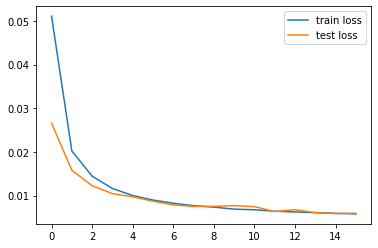

In [13]:
plt.plot(autoencoder.history.history['loss'], label='train loss')
plt.plot(autoencoder.history.history['val_loss'], label='test loss')
plt.legend()
plt.show();

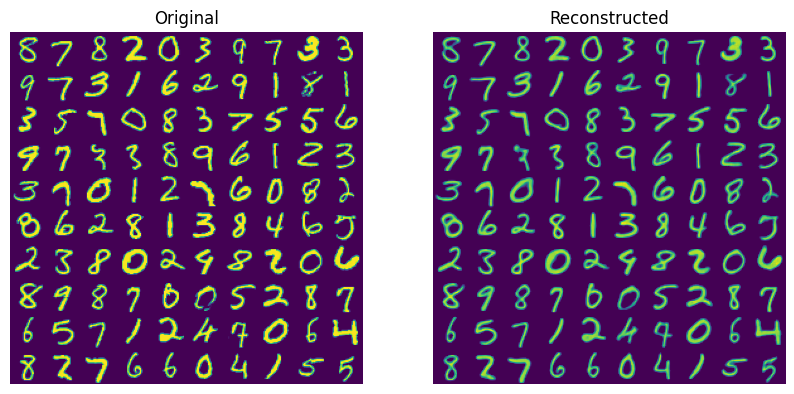

In [14]:
np.random.seed(23864)
idx = np.random.randint(len(X_test), size=100)
rec_X_test = autoencoder(X_test, training=False).numpy()

def plot100(imgs):
  plt.imshow(
      np.array(imgs).reshape(
          (10, 10) + imgs.shape[1:3]
      ).transpose(0, 2, 1, 3).reshape(np.array(imgs.shape[1:]) * 10)
  )
  plt.axis('off')

plt.figure(figsize=(10, 5), dpi=100)
plt.subplot(1, 2, 1)
plt.title("Original")
plot100(X_test[idx])
plt.subplot(1, 2, 2)
plt.title("Reconstructed")
plot100(rec_X_test[idx])

### Exercise: interpolating between bottleneck representations

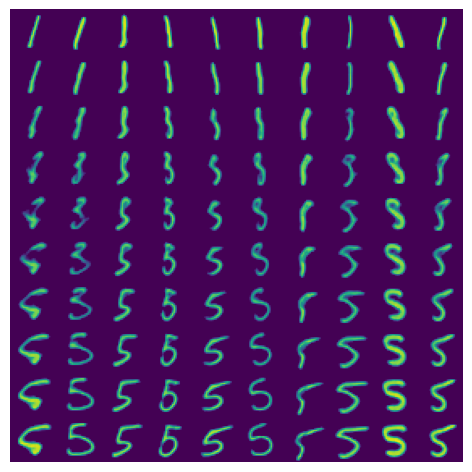

In [15]:
digit_1 = 5
digit_2 = 1

# Let's take 10 images of digit_1 and digit_2:
digits_1 = X_test[y_test == digit_1][:10]
digits_2 = X_test[y_test == digit_2][:10]

# Calculate the encoded representations of these digits:
representation_1 = encoder(digits_1,training=False).numpy()
representation_2 = encoder(digits_2,training=False).numpy()

# Now create a 10x10x<BOTTLENECK_SIZE> matrix of linear interpolations between
# the two representations:
exp_1 = representation_1[None,:,:]+np.zeros((10,10,32))
exp_2 = representation_2[None,:,:]+np.zeros((10,10,32))
x = np.linspace(0,1,10)
representation_mixed = exp_1*x[:,None,None]+exp_2*(1-x)[:,None,None]

# Then decode the images from the mixed representations:
mixed_imgs = decoder(representation_mixed.reshape((100,32)),training = False).numpy()

plt.figure(figsize=(6, 6), dpi=100)
plot100(mixed_imgs)

# Training a classifier

Now we'll use the encoder to train a classifier on its outputs. We don't want to update the encoder's weights anymore:

In [ ]:
encoder.trainable = False

In [ ]:
classifier = tf.keras.Sequential([
    encoder,
    ll.Dense(10)
  ],
  name='classifier')

classifier.summary()
classifier.compile(optimizer=tf.optimizers.RMSprop(learning_rate=0.05), loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                   metrics=[tf.metrics.SparseCategoricalAccuracy()])

Now let's fit the classifier on first 300 labeled objects:

In [ ]:
classifier.fit(x=X_train[:300], y=y_train[:300], batch_size=128, epochs=50, validation_data=(X_test, y_test));

We got test accuracy up to 90% by training on just 300 objects! Note that there is 10000 objects in the test set.

In [ ]:
plt.figure(figsize=(16, 7))
plt.subplot(1, 2, 1)
plt.plot(classifier.history.history['loss'], label='train')
plt.plot(classifier.history.history['val_loss'], label='test')
plt.legend()
plt.title('Cross-entropy')

plt.subplot(1, 2, 2)
plt.plot(classifier.history.history['sparse_categorical_accuracy'], label='train')
plt.plot(classifier.history.history['val_sparse_categorical_accuracy'], label='test')
plt.legend()
plt.title('Accuracy')
plt.show();


Now let's imagine we have similar architecture to train from scratch on just 300 objects:

In [ ]:
encoder.trainable = True
encoder.load_weights('encoder_untrained.h5')

classifier = tf.keras.Sequential([
  encoder,
  ll.Dense(10),
  ],
  name='classifier')

classifier.summary()
classifier.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                   metrics=[tf.metrics.SparseCategoricalAccuracy()])

In [ ]:
classifier.fit(x=X_train[:300], y=y_train[:300], batch_size=64, epochs=50, validation_data=(X_test, y_test));

This results in a heavy overfit:

In [ ]:
plt.figure(figsize=(16, 7))
plt.subplot(1, 2, 1)
plt.plot(classifier.history.history['loss'], label='train')
plt.plot(classifier.history.history['val_loss'], label='test')
plt.legend()
plt.title('Cross-entropy')

plt.subplot(1, 2, 2)
plt.plot(classifier.history.history['sparse_categorical_accuracy'], label='train')
plt.plot(classifier.history.history['val_sparse_categorical_accuracy'], label='test')
plt.legend()
plt.title('Accuracy')
plt.show();


# Simultaneously optimizing the AE and classifier

Before running this code, make sure to re-initialize the autoencoder and the classifier network (run corresponding cells above).

In [ ]:
X_train_labeled, X_train_unlabeled = X_train[:300], X_train[300:]
y_train_labeled = y_train[:300]

In [ ]:
from itertools import cycle

In [ ]:
def gen_unlabeled(batch_size):
  ids = np.arange(len(X_train_unlabeled))
  np.random.shuffle(ids)
  shuffled_X_train_unlabeled = X_train_unlabeled[ids]
  for i in range(0, len(X_train_unlabeled), batch_size):
    yield shuffled_X_train_unlabeled[i:i+batch_size]


In [ ]:
len(X_train_unlabeled)

In [ ]:
unlabeled_generator = iter(cycle(gen_unlabeled(256)))

In [ ]:
classifier.summary()

In [ ]:
variables = classifier.trainable_variables + decoder.trainable_variables

In [ ]:
opt = tf.optimizers.Adam()

In [ ]:
from IPython.display import clear_output

In [ ]:
N_EPOCHS = 100
BATCH_SIZE = 16

LAMBDA = 0.1
history_ae = []
history_cl = []
history_tot = []
for i_epoch in range(N_EPOCHS):
  print("Working on ep #", i_epoch)
  ids = np.arange(len(X_train_labeled))
  np.random.shuffle(ids)

  epoch_ae_loss = 0
  epoch_cl_loss = 0
  epoch_total_loss = 0

  for i_image in range(0, len(X_train_labeled), BATCH_SIZE):
    X_batch = X_train_labeled[ids][i_image:i_image + BATCH_SIZE]
    y_batch = y_train_labeled[ids][i_image:i_image + BATCH_SIZE]
    X_batch_unlabeled = next(unlabeled_generator)

    with tf.GradientTape() as t:
      reco = decoder(encoder(X_batch_unlabeled))
      preds = classifier(X_batch)

      ae_loss = tf.reduce_mean(tf.reduce_sum((X_batch_unlabeled - reco)**2, axis=(1, 2)))
      cl_loss = tf.reduce_mean(tf.losses.sparse_categorical_crossentropy(y_batch, preds, from_logits=True))

      loss = cl_loss + LAMBDA * ae_loss
    epoch_ae_loss += ae_loss.numpy()
    epoch_cl_loss += cl_loss.numpy()
    epoch_total_loss += loss.numpy()
    grads = t.gradient(loss, variables)
    opt.apply_gradients(zip(grads, variables))
  history_ae.append(epoch_ae_loss / len(X_train_labeled))
  history_cl.append(epoch_cl_loss / len(X_train_labeled))
  history_tot.append(epoch_total_loss / len(X_train_labeled))

  if i_epoch % 10 == 0:
    clear_output(wait=True)
    plt.figure(figsize=(9, 6))
    plt.plot(history_ae, label='ae loss')
    plt.plot(history_cl, label='cl loss')
    plt.plot(history_tot, label='total')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show();


In [ ]:
plt.figure(figsize=(9, 6))
plt.plot(history_ae, label='ae loss')
plt.plot(history_cl, label='cl loss')
plt.plot(history_tot, label='total')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show();

In [ ]:
preds_train = classifier(X_train).numpy().argmax(axis=1)
preds_test  = classifier(X_test ).numpy().argmax(axis=1)

print((preds_train == y_train).mean())
print((preds_test == y_test).mean())